In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.integrate as si
import scipy.optimize as so
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
from jax.config import config
config.update("jax_enable_x64", True)

<h1>Forward Problem</h1>

In [5]:
# size of spatial domain
L = 10.0
# number of real space grid points (for plotting)
numx = 1025
# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
# n = -numF to n = numF
numfour = 12  # 32

# matrix for converting Fourier representation to real space
fournvec = np.arange(-numfour, numfour + 1) # fournvec=-nfb,...,0,...,nfb
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)
print('Shape fourtox:', fourtox.shape)

Shape fourtox: (25, 1025)


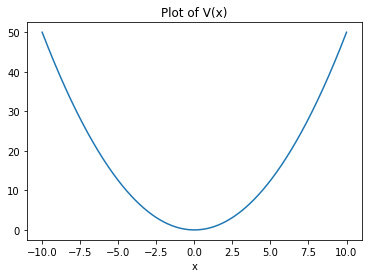

In [6]:
def v(z):
    # harmonic oscillator potential (should be exact for Chebyshev)
    return 0.5 * z**2
    # symmetric double well potential
    # return 2.5e-3 * (z**2 - 25)**2
    # asymmetric double well potential
    # c0 = 4.35; c1 = 9.40e-1; c2 = -3.56e-1; c3 = -4.66e-2
    # c4 = 1.46e-2; c5 = 6.76e-4; c6 = -1.26e-4; c7 = -5.43e-6
    # c8 = 4.12e-7; c9 = 1.65e-8
    # x = z + 0.8
    # return 0.5 * (c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 \
    #        + c6*x**6 + c7*x**7 + c8*x**8 + c9*x**9)
    # non-polynomial potentials
    # return np.sin(0.4 * z - 1)
    # return np.sin((0.5 * z)**2)
    # return 15 * (-np.cos(z) + np.sin((0.5 * z)**2 - 0.2 * z))
    # soft coulomb potential
    # return -1 / np.sqrt(z**2 + 0.25)

# compute true potential on real space grid for plotting
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [7]:
# transform potential to Fourier representation

fourvtoep = []
for thisfourn in range(2 * numfour + 1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    fourvtoep.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
vmattrue = sl.toeplitz(r=fourvtoep, c=np.conj(fourvtoep))

print('Shape vmattrue:', vmattrue.shape)

Shape vmattrue: (25, 25)


l2 error psi0: 5.861156835595539e-06
l-infinity error psi0: 2.2314871751944757e-06


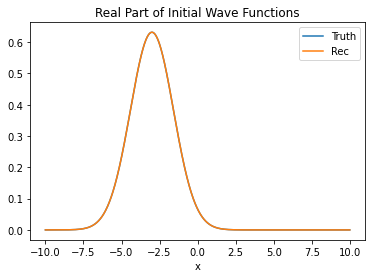

In [41]:
# define initial states and transform to Fourier basis

def psi0(x):
    return np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 3)**2 / 4) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 6)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x + 6)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25


# compute psi0 normalization term
psi0_prob_intgrnd = lambda x: np.abs(psi0(x)) ** 2
psi0_norm = np.sqrt(si.quad(psi0_prob_intgrnd, -L, L)[0])

# normalized psi function (for integration)
norm_psi0_fn = lambda x: psi0(x) / psi0_norm

# compute the Fourier representation of psi0fn
norm_psi0 = []
for thisfourn in range (numfour + 1):
    def intgrnd(x):
        return norm_psi0_fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    norm_psi0.append(si.quad(rintgrnd, -L, L)[0] \
                       + 1j * si.quad(iintgrnd, -L, L)[0])

a0 = np.concatenate([np.conjugate(np.flipud(norm_psi0[1:])), norm_psi0])

normpsi0x = norm_psi0_fn(xvec)
normpsi0xrec = a0 @ fourtox

# check if Fourier representation is close to truth
print(f'l2 error psi0:', nl.norm(normpsi0x - normpsi0xrec))
print(f'l-infinity error psi0:', np.max(np.abs(normpsi0x - normpsi0xrec)))

# plot the real part of the normalized psi0
plt.plot(xvec, normpsi0xrec.real, label=f"Truth")
plt.plot(xvec, normpsi0xrec.real, label=f"Rec")
plt.title('Real Part of Initial Wave Functions')
plt.xlabel('x')
plt.legend()
plt.show()

---
**Forward Propagation**

In [42]:
# Eigendecomposition of Hamiltonian

# kinetic operator in the Fourier representation
# (this is constant for a given system)
kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))

# Hamiltonian operator in the Fourier representation
hmattrue = kmat + vmattrue

# check if the Hamiltonian matrix is Hermitian
print('hmattrue Hermitian check (should be close to zero):', nl.norm(hmattrue - hmattrue.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
spctrue, stttrue = nl.eigh(hmattrue)

# check if the decomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('hmattrue diagonalized check (should be close to zero):', nl.norm(hmattrue @ stttrue - stttrue @ np.diag(spctrue)), sep='\n')

# check if the eigenstates are unitary
print('stttrue unitary check (should be close to zero):', nl.norm(stttrue @ stttrue.T.conj() - np.eye(2 * numfour + 1)), sep='\n')

hmattrue Hermitian check (should be close to zero):
0.0
hmattrue diagonalized check (should be close to zero):
1.0639794711607527e-13
stttrue unitary check (should be close to zero):
7.392035012284071e-15


[0.50000034 1.50001041 2.50014751 3.50127861 4.50753787 5.53192104]


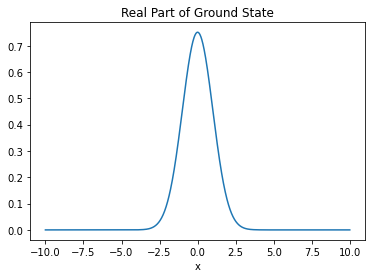

Quick normalization check (should be close to 1):
1.0000000000062457
Accurate normalization check (should be close to 1):
0.999999999999999


In [43]:
# plot ground state of Eigendecomposition

# find indices that sort eigenvalues
ordering = np.argsort(spctrue)

# print the first few eigenvalues
print(spctrue[ordering[:6]])

# pick out and plot real part of the ground state
groundstate = ordering[0]
wavefn = stttrue[:, groundstate] @ fourtox
plt.plot(xvec, np.real(wavefn))
plt.title('Real Part of Ground State')
plt.xlabel('x')
plt.show()

# quick and dirty check of normalization
print('Quick normalization check (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Accurate normalization check (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

In [44]:
# Propagate

# set time-step size
dt = 1e-2

# set number of time steps
# trajectory length is numts + 1 (initial state + numts steps)
numts = 10  # 100  # 200


# compute propagator matrix
propatrue = stttrue @ np.diag(np.exp(-1j * spctrue * dt)) @ stttrue.conj().T

# propagate system starting from initial "a" state
amattrue = [a0.copy()]
for i in range(numts):
    amattrue.append(propatrue @ amattrue[-1])

amattrue = np.array(amattrue)

print('Shape amattrue:', amattrue.shape)

print('Done propagating')

Shape amattrue: (11, 25)
Done propagating


Shape psimattrue: (11, 1025)
Shape probmattrue: (11, 1025)
Shape normmattrue: (11,)


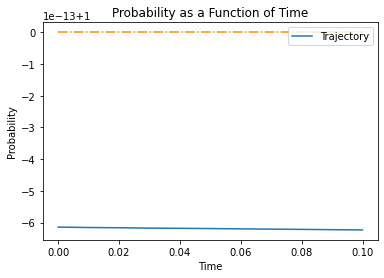

In [45]:
# check if system's state remains normalized for the propagation

psimattrue = amattrue @ fourtox
print('Shape psimattrue:', psimattrue.shape)

probmattrue = np.abs(psimattrue) ** 2
print('Shape probmattrue:', probmattrue.shape)

normmattrue = si.trapezoid(probmattrue, xvec)
print('Shape normmattrue:', normmattrue.shape)

# plot normalization (should be almost flat line at 1)
plt.plot(np.arange(numts + 1) * dt, normmattrue, label=f'Trajectory')

plt.hlines(1, 0, numts * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Probability as a Function of Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

<h1>Inverse Problem</h1>

In [46]:
# code for constructing a toeplitz matrix from the
# Fourier representation
# flat_toep_vec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])

numtoepelms = 2 * numfour + 1
aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
toepindxmat = np.array(aa + bb)
print(toepindxmat.shape)

(25, 25)


In [47]:
# check if index method makes same vmat
# should be close to 0

print(nl.norm(vmattrue - np.concatenate([np.flipud(np.conj(fourvtoep)), fourvtoep[1:]])[toepindxmat]))

0.0


Shape expmat: (1, 25, 1025)
Shape expanded probmattrue: (11, 1, 1025)
(11, 25)


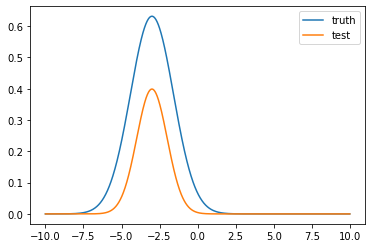

In [56]:
# probability training data
# we need |\psi(t)|^2 in the Fourier representation

# we have amat, which needs to be converted into a the
# function \psi_r(x), where r is the time step
# so we can then integrate to get \beta_{r, n}, where n
# identifies which basis the \beta coefficient is for

# it would be best if we used a function, but we can use a
# discrete integration method like si.trapezoid and the
# values of \psi_r(x) evaluated on our real space grid

meshn, meshx = np.meshgrid(fournvec, xvec)
expmat = np.exp(-1j * np.pi * np.transpose(meshn * meshx) / L) / (2 * L)
expmat = np.expand_dims(expmat, 0)
print('Shape expmat:', expmat.shape)

print('Shape expanded probmattrue:', np.expand_dims(probmattrue, 1).shape)

betamat = si.trapezoid(np.expand_dims(probmattrue, 1) * expmat, xvec, axis=2)
print(betamat.shape)

plt.plot(xvec, normpsi0x, label='truth')
plt.plot(xvec, probmattrue[0], label='test')
plt.legend()
plt.show()

Shape beta0: (25,)
0.4123625851092795
0.17360679775000964


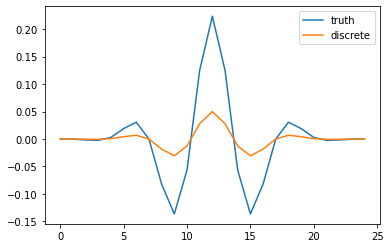

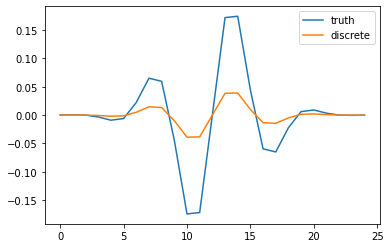

In [54]:
# check accuracy of discrete integration method

prob_psi0 = []
for thisfourn in range (numfour + 1):
    def intgrnd(x):
        return np.abs(norm_psi0_fn(x))**2 * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    prob_psi0.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])

beta0 = np.concatenate([np.conjugate(np.flipud(prob_psi0[1:])), prob_psi0])

print('Shape beta0:', beta0.shape)
print(nl.norm(beta0 - betamat[0]))
print(np.max(np.abs(beta0 - betamat[0])))

plt.plot(beta0.real, label='truth')
plt.plot(betamat[0].real, label='discrete')
plt.legend()
plt.show()

plt.plot(beta0.imag, label='truth')
plt.plot(betamat[0].imag, label='discrete')
plt.legend()
plt.show()

In [ ]:





rtrna0 = np.concatenate([np.conjugate(np.flipud(norm_psi0fn[1:])), norm_psi0fn])

rtrnnormpsi0x = norm_psi0fn_fn(xvec)


print('Shape probmattrue:', probmattrue.shape)

In [19]:
# objective

slt = 10

thisavec = amattrue[0, slt]
thisprob = probmattruevec[0, slt]

objective = 0
for j in range(-numfour, numfour+1):
    thissum = 0
    for k in range(-numfour, numfour+1):
        if np.abs(j + k) <= numfour:
            thissum += thisavec[j + k + numfour] * np.conj(thisavec[k + numfour])
    fourprob = (thissum / np.sqrt(2 * L))
    print(fourprob)
    err = np.abs(fourprob - thisprob[j + numfour])**2
    print('err:', err)
    objective += err

print(objective)

(4.9246979380442355e-05+0.00018704220400403171j)
err: 3.741005105525908e-08
(-0.000375210667600882+0.0004638259723610288j)
err: 3.559175778549306e-07
(-0.0016667581694325018-7.856468274117698e-05j)
err: 2.784255293316061e-06
(-0.0023399999014574973-0.00352574893242128j)
err: 1.790651162938932e-05
(0.0033531337641837244-0.009134080619910228j)
err: 9.467458302090783e-05
(0.019488844766937845-0.005629426872359972j)
err: 0.00041145323178500595
(0.03037320922435669+0.023406276141571574j)
err: 0.0014689679393454906
(-0.0015470697874770266+0.06570226505954269j)
err: 0.004320115085689706
(-0.0837388086998422+0.058462423951551615j)
err: 0.010810357601143543
(-0.1362095899198419-0.04639426623532098j)
err: 0.024223351962130706
(-0.05515556989398161-0.17535309036238503j)
err: 0.04106571992802929
(0.12596008621987217-0.17166360366436764j)
err: 0.029518567550677156
(0.2236067977498387+0j)
err: 0.0002590675092692213
(0.12596008621987217+0.17166360366436764j)
err: 0.04409352289601401
(-0.0551555698939

In [39]:
# objective function

def probobj(cff):
    # turn Fourier space coefficients of the potential
    # into vmat for propagation
    vmat = jnp.concatenate([jnp.flipud(jnp.conj(cff)), cff[1:]])[toepindxmat]

    # Hamiltonian operator in the Fourier representation
    hmat = kmat + vmat

    # eigen-decomposition of the Hamiltonian matrix
    spc, stt = jnl.eigh(hmat)

    # compute propagator matrix
    propa = stt @ jnp.diag(np.exp(-1j * spc * dt)) @ stt.conj().T

    amatvec = []
    # propagate system starting from initial "a" state
    for thisa0 in a0:
        tempahatmat = [thisa0.copy()]
        for i in range(numts):
            tempahatmat.append(propa @ tempahatmat[-1])
        amatvec.append(tempahatmat)

    amatvec = jnp.array(amatvec)
    print(jnl.norm(amatvec - jnp.array(amattrue)))

    # compute objective functions
    objective = 0
    for i in range(jaxprobmattruevec.shape[0]):
        thisamat = amatvec[i]
        thisprobmat = jaxprobmattruevec[i]
        for r in range(thisamat.shape[0]):
            thissum = 0
            for j in range(-numfour, numfour+1):
                for k in range(-numfour, numfour+1):
                    if abs(j+k) <= numfour:
                        thissum += thisamat[r, k + j + numfour] * jnp.conj(thisamat[r, k])
                objective += jnp.abs(thissum / jnp.sqrt(2 * L) - thisprobmat[r, j + numfour])**2

    return objective

In [40]:
# check objective with true potential
print(probobj(jnp.array(fourvtoep)))

1.0040633196751477e-13
()
11.736956194549274


In [ ]:
# JAX grad of the objective

In [ ]:
# check grad of objective with true potential

---
**Initialize with perturbed true coefficients**

In [ ]:
seed = 1234  # set to None for random initialization
cfftrub = cfftrue.copy()
cfftrub += 0.25 * np.random.default_rng(seed).normal(size=cfftrue.shape)

In [ ]:
restrubjaxgrad = so.minimize(jitcobjfn, cfftrub, jac=jaxgradcobjfn, tol=1e-12, options={'maxiter': 200, 'disp': True, 'gtol': 1e-15}).x

In [ ]:
def sqrerrorfn(x, cffs):
    return (ss.eval_chebyt(chebnvec, x / L) @ cffs - v(x)) ** 2

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(cfftrue)))[0], sep='\n')

In [ ]:
print('Objective of the Learned Coefficients:', cobjfn(restrubjaxgrad), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(restrubjaxgrad)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(restrubjaxgrad)))[0], sep='\n')

# plot learned vs true
# plt.plot(xvec, chebtox @ cfftrub, label='initial')
plt.plot(xvec, chebtox @ restrubjaxgrad, label='learned')
plt.plot(xvec, vxvec, label='Truth')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---
**Initialize with random coefficients**

In [32]:
seed = 1234  # set to None for random initialization
cffform = np.random.default_rng(seed).uniform(low=-5.0, high=5.0, size=cfftrue.shape)

In [33]:
resform = so.minimize(jitcobjfn, cffform, jac=jaxgradcobjfn, tol=1e-15, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-14}).x

         Current function value: 0.000000
         Iterations: 134
         Function evaluations: 313
         Gradient evaluations: 297


Objective of the Learned Coefficients:
3.225981834017433e-24
Vec L2 Norm of Gradient of the Learned Coefficients:
1.3591848931107718e-12
Continuous L2 Error of Potential using Quadrature Method:
8.808442253066008e-11


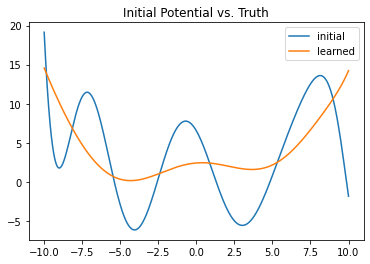

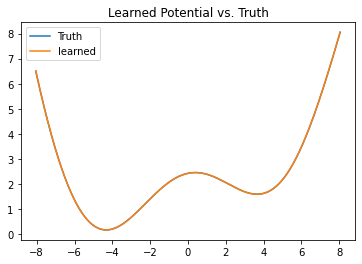

In [34]:
print('Objective of the Learned Coefficients:', cobjfn(resform), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(resform)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(resform)))[0], sep='\n')

# plot initial vs learned
plt.plot(xvec, chebtox @ cffform, label='initial')
plt.plot(xvec, chebtox @ resform, label='learned')
plt.title('Initial Potential vs. Truth')
plt.legend()
plt.show()

# plot true vs learned
plt.plot(xvec[100:-100], vxvec[100:-100], label='Truth')
plt.plot(xvec[100:-100], (chebtox @ resform)[100:-100], label='learned')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---
* Forward Problem
    * Computational Variables
    * Potential (real space and Fourier basis)
    * Initial wave function (real and Fourier)
    * Solution to forward problem
* Inverse Problem
    * Training data (prob density - new)
    * Objective (new)
    * JAX grad of objective
    * Solver (optimizer)